In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [87]:
df = pd.read_csv('../data/icu_ibd_all_table.csv')
df['intime'] = pd.to_datetime(df['intime'])
df.shape

(1161, 32)

In [88]:
df2 = pd.read_csv('../data/patients_ibd.csv')


func = lambda x: pd.to_datetime('{}-01-01'.format(x))
df2['anchor_year'] = df2['anchor_year'].apply(func)

df2.shape

(2417, 6)

In [89]:
data = df.merge(df2[['subject_id', 'anchor_year']], on='subject_id', how='left')
data['age'] = ((data['intime'] - data['anchor_year']).dt.days) / 365 + data['age']

In [90]:
for col in data.columns:
    print(col, end=' ')
    print(data[col].isna().sum(), end=' - ')
    print(len(data[col].unique()))

hadm_id 0 - 1161
subject_id 0 - 683
intime 0 - 1161
outtime 0 - 1161
los 0 - 1159
mortality 0 - 2
gender 0 - 2
age 0 - 1128
weight 1066 - 28
bmi 1070 - 25
heart_rate 1 - 108
systolic_pressure 1099 - 17
diastolic_pressure 1099 - 15
respiratory_rate 1 - 37
temperature 962 - 45
white_blood_cell 1155 - 5
hematocrit 18 - 252
red_blood_cell 705 - 68
rdw 17 - 122
platelet 18 - 454
mcv 17 - 57
mch 17 - 157
hemoglobin 16 - 102
CRP 1161 - 1
race 18 - 25
language 18 - 3
marital_status 32 - 5
insurance 18 - 4
die_in_icu 0 - 2
uc_only 0 - 2
cd_only 0 - 2
uc_cd 0 - 2
anchor_year 0 - 93


In [91]:
cols_except = [
    'hadm_id',
    'subject_id',
    'intime',
    'outtime',
    # 'los',
    'mortality',
    'weight',
    'bmi',
    'systolic_pressure',
    'diastolic_pressure',
    'temperature',
    'white_blood_cell',
    'red_blood_cell',
    'CRP',
    'die_in_icu',
    'anchor_year',
    'uc_cd'
]

cols_include = [col for col in data.columns if col not in cols_except]

data = data[cols_include]

In [92]:
X = data[ ~data[cols_include].isna().any(axis=1) ]


def parse_race(race):
    if 'WHITE' in race:
        return 'WHITE'
    elif 'BLACK' in race:
        return 'BLACK'
    elif 'HISPANIC' in race or 'LATINO' in race:
        return 'HISPANIC/LATINO'
    elif 'ASIAN' in race:
        return 'ASIAN'
    else:
        return 'OTHER'


X.loc[:, 'race'] = X['race'].apply(parse_race)

for col in ['language', 'race', 'marital_status', 'insurance']:
    print(X[col].value_counts())

X = pd.get_dummies(X, columns=['race', 'language', 'marital_status', 'insurance'], prefix=['race', 'language', 'marital_status', 'insurance'])

language
ENGLISH    1056
?            52
Name: count, dtype: int64
race
WHITE              918
BLACK              101
OTHER               61
HISPANIC/LATINO     21
ASIAN                7
Name: count, dtype: int64
marital_status
MARRIED     510
SINGLE      367
WIDOWED     136
DIVORCED     95
Name: count, dtype: int64
insurance
Medicare    516
Other       505
Medicaid     87
Name: count, dtype: int64


In [93]:
cols = ['age', 'heart_rate', 'respiratory_rate', 'hematocrit', 'rdw',
       'platelet', 'mcv', 'mch', 'hemoglobin',]

tmp = X.loc[:, cols]

tmp = ( tmp - tmp.mean() ) / ( tmp.std() )

X.loc[:, cols] = tmp

In [94]:
X.loc[:, [col for col in X.columns if col not in cols+['los']]] = \
    X.loc[:, [col for col in X.columns if col not in cols+['los']]].astype(int)

C:\Users\sitdo\AppData\Local\Temp\ipykernel_24428\2195305398.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X.loc[:, [col for col in X.columns if col not in cols+['los']]] = \
C:\Users\sitdo\AppData\Local\Temp\ipykernel_24428\2195305398.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X.loc[:, [col for col in X.columns if col not in cols+['los']]] = \
C:\Users\sitdo\AppData\Local\Temp\ipykernel_24428\2195305398.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dty

In [98]:
X['los'] = np.log(X['los'])

X.to_csv('../new r scripts/data_norm.csv')

In [99]:
X.describe()

,los,gender,age,heart_rate,respiratory_rate,hematocrit,rdw,platelet,mcv,mch,...,race_WHITE,language_?,language_ENGLISH,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SINGLE,marital_status_WIDOWED,insurance_Medicaid,insurance_Medicare,insurance_Other
count,1108.000000,1108.000000,1.108000e+03,1.108000e+03,1.108000e+03,1.108000e+03,1.108000e+03,1.108000e+03,1.108000e+03,1.108000e+03,...,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000
mean,0.715748,0.456679,6.284584e-16,-2.837682e-16,9.619261e-18,2.885778e-16,1.470144e-15,1.763531e-17,6.637290e-16,-1.386777e-15,...,0.828520,0.046931,0.953069,0.085740,0.460289,0.331227,0.122744,0.078520,0.465704,0.455776
std,0.874133,0.498345,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.377098,0.211587,0.211587,0.280106,0.498646,0.470867,0.328291,0.269109,0.499048,0.498265
min,-1.871147,0.000000,-2.785966e+00,-3.251152e+00,-3.337023e+00,-3.396251e+00,-6.396416e+00,-1.545146e+00,-1.052960e+01,-9.363154e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.082846,0.000000,-6.592649e-01,-7.167293e-01,-7.362575e-01,-7.299494e-01,-7.214580e-01,-6.618259e-01,-5.337390e-01,-5.572986e-01,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.632372,0.000000,5.882926e-03,-5.777935e-02,-1.294123e-01,-8.091551e-02,-1.658676e-01,-1.753596e-01,-6.881540e-02,4.454043e-02,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.214329,1.000000,8.088117e-01,6.011706e-01,4.774329e-01,6.207427e-01,5.087778e-01,3.879171e-01,5.413968e-01,5.830280e-01,...,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,3.938743,1.000000,2.182434e+00,4.859001e+00,5.332195e+00,4.111492e+00,4.080430e+00,5.668636e+00,3.650573e+00,3.528872e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


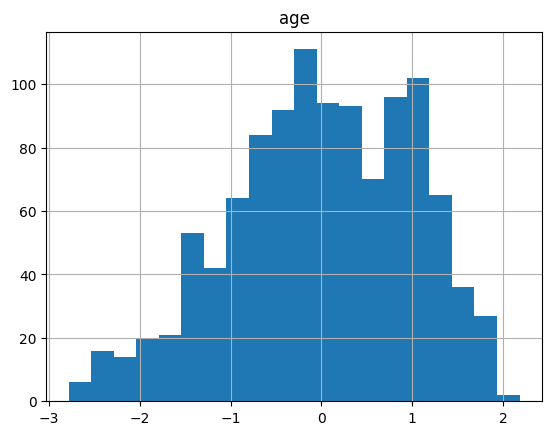

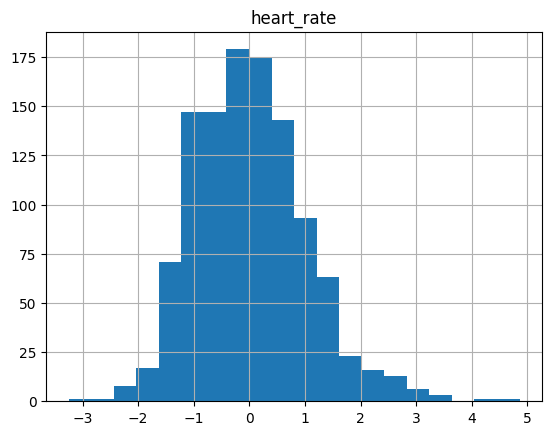

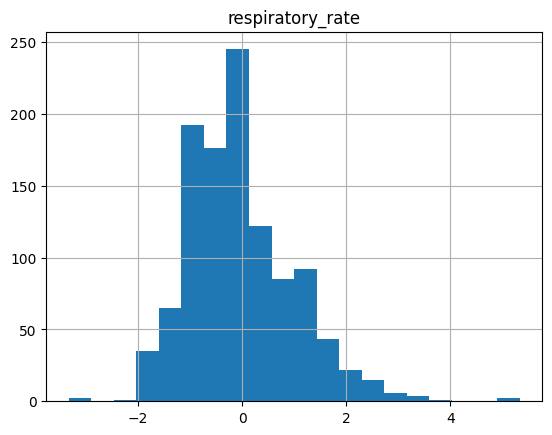

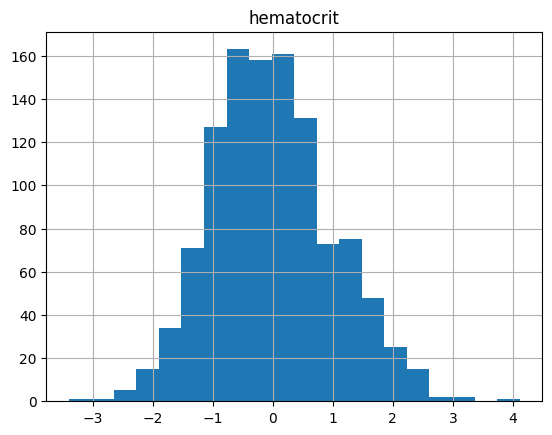

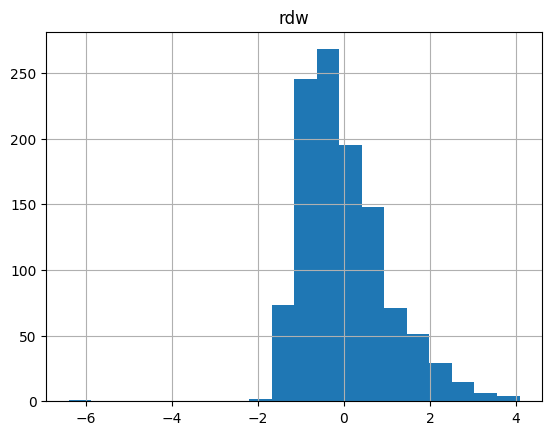

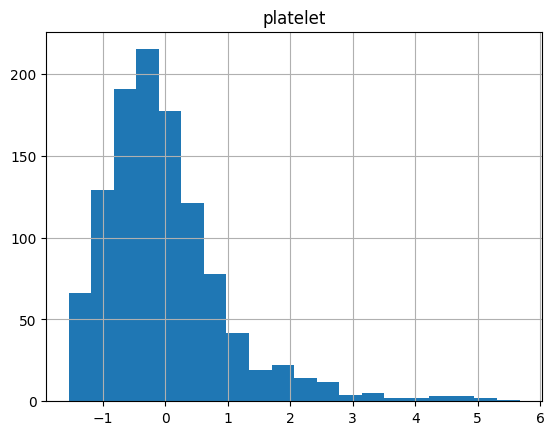

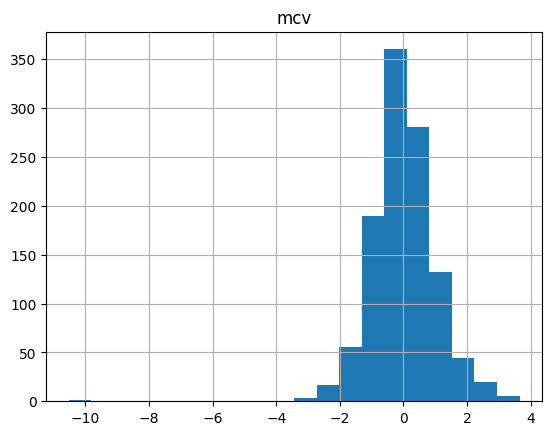

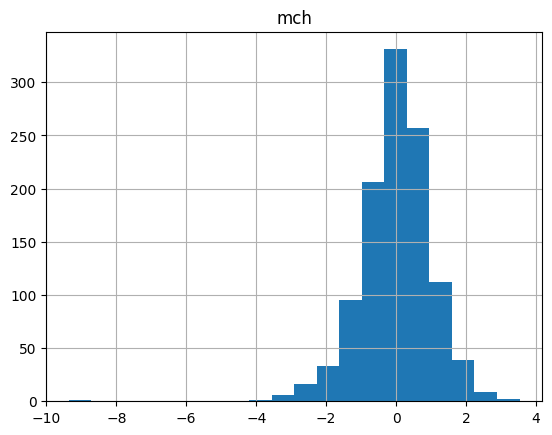

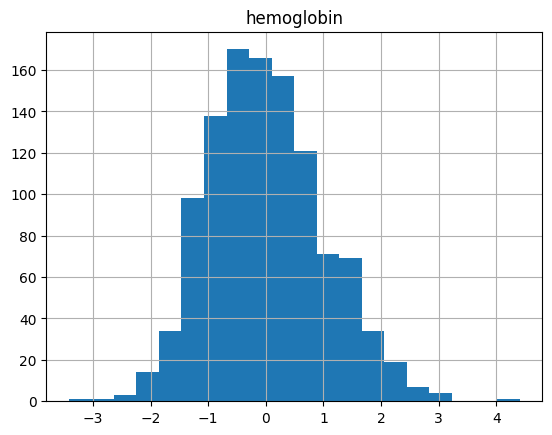

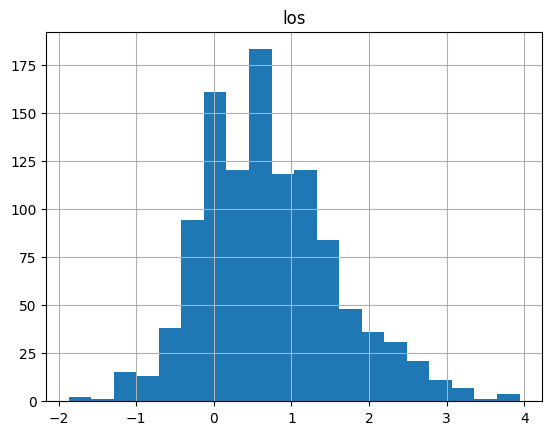

In [101]:
for col in cols+['los']:
    # plt.boxplot(X[col])
    X[col].hist(bins=20)
    plt.title(col)
    plt.show()

(array([  2.,   1.,  15.,  13.,  38.,  94., 161., 120., 183., 118., 120.,
         84.,  48.,  36.,  31.,  21.,  11.,   7.,   1.,   4.]),
 array([-1.87114689, -1.58065241, -1.29015792, -0.99966343, -0.70916895,
        -0.41867446, -0.12817998,  0.16231451,  0.452809  ,  0.74330348,
         1.03379797,  1.32429246,  1.61478694,  1.90528143,  2.19577591,
         2.4862704 ,  2.77676489,  3.06725937,  3.35775386,  3.64824834,
         3.93874283]),
 <BarContainer object of 20 artists>)

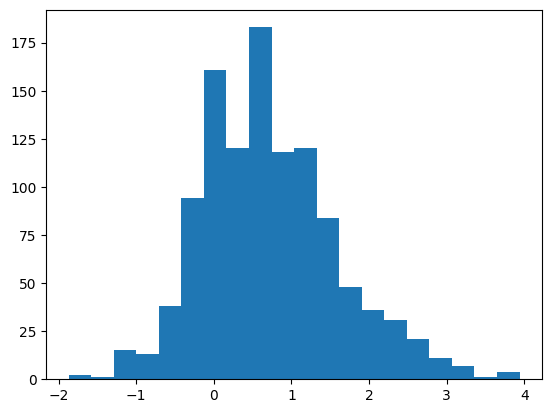

In [97]:
plt.hist(np.log(X['los']), bins=20)